# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.scaler.force import EnergyForceExtensiveScaler
scaler = EnergyForceExtensiveScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
_, eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "module_name": "kgcnn.literature.Schnet", 
    "class_name":"make_model", 
    "output_as_dict":True,
    "config":{
        "name": "Schnet",
        "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                   {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                   {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
        "make_distance": True, "expand_distance": True,
        "interaction_args": {"units": 128, "use_bias": True,
                             "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
        "verbose": 10,
        "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                     "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
        "output_embedding": "graph", "output_to_tensor": True,
        "use_output_mlp": True,
        "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                       "activation": ["kgcnn>shifted_softplus", "linear"]}},
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model.model_config["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 5s 27ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9751 - energy_loss: 0.2458 - force_loss: 0.9365 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9411 - energy_loss: 0.2178 - force_loss: 0.9362 - 527ms/epoch - 66ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9259 - energy_loss: 0.2091 - force_loss: 0.9358 - 525ms/epoch - 66ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8948 - energy_loss: 0.2063 - force_loss: 0.9344 - 527ms/epoch - 66ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.7383 - energy_loss: 0.2363 - force_loss: 0.9251 - 525ms/epoch - 66ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.4854 - energy_loss: 0.3265 - force_loss: 0.9079 - 524ms/epoch - 66ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.1772 - energy_loss: 0.5393 - force_loss: 0.8819 - 527ms/epoch - 66ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.8055 - energy_loss: 1.4119 - force_loss: 0.8697 - 527ms/epoch - 66ms/step
Epoch 9/1500
8/8 - 1s - loss: 18.2724 - energy_loss: 0.6026 - force_loss: 0.8835 - 524ms/epoch - 66ms/step
Epoch 10/1500
8/8 - 1s - loss: 17.3607 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.4362 - energy_loss: 0.7607 - force_loss: 0.2838 - 522ms/epoch - 65ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.2859 - energy_loss: 0.7373 - force_loss: 0.2774 - 522ms/epoch - 65ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.2327 - energy_loss: 0.7786 - force_loss: 0.2727 - 519ms/epoch - 65ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.1373 - energy_loss: 0.7280 - force_loss: 0.2705 - 521ms/epoch - 65ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.1761 - energy_loss: 0.7625 - force_loss: 0.2707 - 517ms/epoch - 65ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.1243 - energy_loss: 0.6864 - force_loss: 0.2719 - 524ms/epoch - 66ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.7109 - energy_loss: 1.2604 - force_loss: 0.2725 - 515ms/epoch - 64ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.7526 - energy_loss: 1.3300 - force_loss: 0.2711 - 516ms/epoch - 64ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.6160 - energy_loss: 1.2205 - force_loss: 0.2698 - 518ms/epoch - 65ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.6004

8/8 - 1s - loss: 4.9291 - energy_loss: 1.0548 - force_loss: 0.1937 - 519ms/epoch - 65ms/step
Epoch 155/1500
8/8 - 1s - loss: 5.1250 - energy_loss: 1.0684 - force_loss: 0.2028 - 517ms/epoch - 65ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.9096 - energy_loss: 0.6813 - force_loss: 0.2114 - 522ms/epoch - 65ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.6992 - energy_loss: 0.6088 - force_loss: 0.2045 - 519ms/epoch - 65ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.5723 - energy_loss: 0.5650 - force_loss: 0.2004 - 514ms/epoch - 64ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.4720 - energy_loss: 0.6211 - force_loss: 0.1925 - 524ms/epoch - 65ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.4891 - energy_loss: 0.5976 - force_loss: 0.1946 - 519ms/epoch - 65ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.3858 - energy_loss: 0.5987 - force_loss: 0.1894 - 519ms/epoch - 65ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.4560 - energy_loss: 0.6153 - force_loss: 0.1920 - 516ms/epoch - 64ms/step
Epoch 163/1500
8/8 - 1s - loss: 5.0289 - en

Epoch 230/1500
8/8 - 1s - loss: 3.1408 - energy_loss: 0.2115 - force_loss: 0.1465 - 519ms/epoch - 65ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.2073 - energy_loss: 0.2821 - force_loss: 0.1463 - 519ms/epoch - 65ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.1391 - energy_loss: 0.2285 - force_loss: 0.1455 - 523ms/epoch - 65ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.4270 - energy_loss: 0.5418 - force_loss: 0.1443 - 515ms/epoch - 64ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5319 - energy_loss: 0.5723 - force_loss: 0.1480 - 520ms/epoch - 65ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.4969 - energy_loss: 0.5735 - force_loss: 0.1462 - 521ms/epoch - 65ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.5014 - energy_loss: 0.5280 - force_loss: 0.1487 - 518ms/epoch - 65ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.6809 - energy_loss: 0.6401 - force_loss: 0.1520 - 517ms/epoch - 65ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.5733 - energy_loss: 0.5715 - force_loss: 0.1501 - 520ms/epoch - 65ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.1101 - energy_loss: 0.3271 - force_loss: 0.1392 - 521ms/epoch - 65ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.2063 - energy_loss: 0.4939 - force_loss: 0.1356 - 520ms/epoch - 65ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.6796 - energy_loss: 0.9030 - force_loss: 0.1388 - 518ms/epoch - 65ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.5865 - energy_loss: 0.8180 - force_loss: 0.1384 - 525ms/epoch - 66ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.1993 - energy_loss: 0.4352 - force_loss: 0.1382 - 518ms/epoch - 65ms/step
Epoch 311/1500
8/8 - 1s - loss: 2.9865 - energy_loss: 0.2648 - force_loss: 0.1361 - 520ms/epoch - 65ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.3835 - energy_loss: 0.5308 - force_loss: 0.1426 - 524ms/epoch - 66ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.4356 - energy_loss: 0.5416 - force_loss: 0.1447 - 517ms/epoch - 65ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.2869 - energy_loss: 0.4986 - force_loss: 0.1394 - 518ms/epoch - 65ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 3.0187 - energy_loss: 0.4555 - force_loss: 0.1282 - 543ms/epoch - 68ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.9614 - energy_loss: 0.4719 - force_loss: 0.1245 - 541ms/epoch - 68ms/step
Epoch 384/1500
8/8 - 1s - loss: 2.9450 - energy_loss: 0.4824 - force_loss: 0.1231 - 538ms/epoch - 67ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.0601 - energy_loss: 0.4442 - force_loss: 0.1308 - 541ms/epoch - 68ms/step
Epoch 386/1500
8/8 - 1s - loss: 3.1610 - energy_loss: 0.4775 - force_loss: 0.1342 - 538ms/epoch - 67ms/step
Epoch 387/1500
8/8 - 1s - loss: 3.0889 - energy_loss: 0.4472 - force_loss: 0.1321 - 539ms/epoch - 67ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.9177 - energy_loss: 0.3598 - force_loss: 0.1279 - 542ms/epoch - 68ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.8320 - energy_loss: 0.4425 - force_loss: 0.1195 - 538ms/epoch - 67ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.8909 - energy_loss: 0.4715 - force_loss: 0.1210 - 539ms/epoch - 67ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.8145 - energy_loss: 0.4530 - force_loss: 0.1181 - 538ms/epoch - 67ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.7807 - energy_loss: 0.4087 - force_loss: 0.1186 - 533ms/epoch - 67ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.8948 - energy_loss: 0.4358 - force_loss: 0.1229 - 532ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.8836 - energy_loss: 0.4482 - force_loss: 0.1218 - 542ms/epoch - 68ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.7491 - energy_loss: 0.4588 - force_loss: 0.1145 - 535ms/epoch - 67ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.5639 - energy_loss: 0.3282 - force_loss: 0.1118 - 531ms/epoch - 66ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.4168 - energy_loss: 0.2255 - force_loss: 0.1096 - 534ms/epoch - 67ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.7240 - energy_loss: 0.5303 - force_loss: 0.1097 - 528ms/epoch - 66ms/step
Epoch 466/1500
8/8 - 1s - loss: 3.1223 - energy_loss: 0.8142 - force_loss: 0.1154 - 536ms/epoch - 67ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.7261 - energy_loss: 0.2847 - force_loss: 0.1221 - 537ms/epoch - 67ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.4557 - energy_loss: 0.2337 - force_loss: 0.1111 - 528ms/epoch - 66ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.3525 - energy_loss: 0.2315 - force_loss: 0.1061 - 539ms/epoch - 67ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.3061 - energy_loss: 0.2202 - force_loss: 0.1043 - 529ms/epoch - 66ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.3746 - energy_loss: 0.2373 - force_loss: 0.1069 - 535ms/epoch - 67ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.6800 - energy_loss: 0.4221 - force_loss: 0.1129 - 533ms/epoch - 67ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.6330 - energy_loss: 0.3775 - force_loss: 0.1128 - 530ms/epoch - 66ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.8912 - energy_loss: 0.4830 - force_loss: 0.1204 - 536ms/epoch - 67ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.8821 - energy_loss: 0.4289 - force_loss: 0.1227 - 534ms/epoch - 67ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.7676 - energy_loss: 0.3973 - force_loss: 0.1185 - 538ms/epoch - 67ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.6054 - energy_loss: 0.3918 - force_loss: 0.1107 - 527ms/epoch - 66ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.6548 - energy_loss: 0.3914 - force_loss: 0.1132 - 534ms/epoch - 67ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.6440 - energy_loss: 0.4017 - force_loss: 0.1121 - 534ms/epoch - 67ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.6610 - energy_loss: 0.4095 - force_loss: 0.1126 - 531ms/epoch - 66ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.6582 - energy_loss: 0.4197 - force_loss: 0.1119 - 532ms/epoch - 66ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.6391 - energy_loss: 0.4127 - force_loss: 0.1113 - 529ms/epoch - 66ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.5109 - energy_loss: 0.4183 - force_loss: 0.1046 - 532ms/epoch - 67ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.5456 - energy_loss: 0.4037 - force_loss: 0.1071 - 540ms/epoch - 68ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.2912 - energy_loss: 0.3315 - force_loss: 0.0980 - 537ms/epoch - 67ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.3905 - energy_loss: 0.3938 - force_loss: 0.0998 - 535ms/epoch - 67ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.3681 - energy_loss: 0.3758 - force_loss: 0.0996 - 533ms/epoch - 67ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.3404 - energy_loss: 0.4050 - force_loss: 0.0968 - 531ms/epoch - 66ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.3096 - energy_loss: 0.3957 - force_loss: 0.0957 - 539ms/epoch - 67ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.3078 - energy_loss: 0.3669 - force_loss: 0.0970 - 532ms/epoch - 67ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.2878 - energy_loss: 0.3917 - force_loss: 0.0948 - 533ms/epoch - 67ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.2237 - energy_loss: 0.3676 - force_loss: 0.0928 - 541ms/epoch - 68ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.2675 - energy_loss: 0.3665 - force_loss: 0.0950 - 532ms/epoch - 67ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.0553 - energy_loss: 0.2113 - force_loss: 0.0922 - 532ms/epoch - 66ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.4017 - energy_loss: 0.4313 - force_loss: 0.0985 - 531ms/epoch - 66ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.6228 - energy_loss: 0.6421 - force_loss: 0.0990 - 534ms/epoch - 67ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.6110 - energy_loss: 0.6589 - force_loss: 0.0976 - 531ms/epoch - 66ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.6533 - energy_loss: 0.6220 - force_loss: 0.1016 - 539ms/epoch - 67ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.2586 - energy_loss: 0.1882 - force_loss: 0.1035 - 534ms/epoch - 67ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.0549 - energy_loss: 0.2049 - force_loss: 0.0925 - 535ms/epoch - 67ms/step
Epoch 769/1500
8/8 - 1s - loss: 1.9347 - energy_loss: 0.1507 - force_loss: 0.0892 - 533ms/epoch - 67ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.0220 - energy_loss: 0.2466 - force_loss: 0.0888 - 541ms/epoch - 68ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.4238 - energy_loss: 0.3895 - force_loss: 0.1017 - 536ms/epoch - 67ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.4015 - energy_loss: 0.3758 - force_loss: 0.1013 - 537ms/epoch - 67ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.4293 - energy_loss: 0.3704 - force_loss: 0.1029 - 532ms/epoch - 67ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.3307 - energy_loss: 0.4027 - force_loss: 0.0964 - 534ms/epoch - 67ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.1920 - energy_loss: 0.3484 - force_loss: 0.0922 - 535ms/epoch - 67ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.2959 - energy_loss: 0.3707 - force_loss: 0.0963 - 530ms/epoch - 66ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.3919 - energy_loss: 0.3750 - force_loss: 0.1008 - 535ms/epoch - 67ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.3183 - energy_loss: 0.3555 - force_loss: 0.0981 - 528ms/epoch - 66ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.2819 - energy_loss: 0.3818 - force_loss: 0.0950 - 531ms/epoch - 66ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.5120 - energy_loss: 0.3698 - force_loss: 0.1071 - 538ms/epoch - 67ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.4088 - energy_loss: 0.3572 - force_loss: 0.1026 - 535ms/epoch - 67ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.2810 - energy_loss: 0.3316 - force_loss: 0.0975 - 533ms/epoch - 67ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.3134 - energy_loss: 0.3421 - force_loss: 0.0986 - 541ms/epoch - 68ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.2603 - energy_loss: 0.1804 - force_loss: 0.1040 - 534ms/epoch - 67ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.2342 - energy_loss: 0.3030 - force_loss: 0.0966 - 531ms/epoch - 66ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.1944 - energy_loss: 0.4009 - force_loss: 0.0897 - 535ms/epoch - 67ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.3261 - energy_loss: 0.3880 - force_loss: 0.0969 - 539ms/epoch - 67ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.3356 - energy_loss: 0.3269 - force_loss: 0.1004 - 536ms/epoch - 67ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 1.7784 - energy_loss: 0.1702 - force_loss: 0.0804 - 542ms/epoch - 68ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.7407 - energy_loss: 0.1505 - force_loss: 0.0795 - 537ms/epoch - 67ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7891 - energy_loss: 0.1485 - force_loss: 0.0820 - 537ms/epoch - 67ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7968 - energy_loss: 0.1870 - force_loss: 0.0805 - 533ms/epoch - 67ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.7686 - energy_loss: 0.1850 - force_loss: 0.0792 - 531ms/epoch - 66ms/step
Epoch 995/1500
8/8 - 1s - loss: 2.0266 - energy_loss: 0.3306 - force_loss: 0.0848 - 533ms/epoch - 67ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.9955 - energy_loss: 0.1903 - force_loss: 0.0903 - 537ms/epoch - 67ms/step
Epoch 997/1500
8/8 - 1s - loss: 2.0966 - energy_loss: 0.4023 - force_loss: 0.0847 - 537ms/epoch - 67ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.3716 - energy_loss: 0.6184 - force_loss: 0.0877 - 540ms/epoch - 68ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 2.1615 - energy_loss: 0.3543 - force_loss: 0.0904 - 533ms/epoch - 67ms/step
Epoch 1067/1500
8/8 - 1s - loss: 2.4124 - energy_loss: 0.5802 - force_loss: 0.0916 - 524ms/epoch - 66ms/step
Epoch 1068/1500
8/8 - 1s - loss: 2.3707 - energy_loss: 0.4407 - force_loss: 0.0965 - 537ms/epoch - 67ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.2633 - energy_loss: 0.3686 - force_loss: 0.0947 - 529ms/epoch - 66ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.5326 - energy_loss: 0.4043 - force_loss: 0.1064 - 534ms/epoch - 67ms/step
Epoch 1071/1500
8/8 - 1s - loss: 2.3177 - energy_loss: 0.3753 - force_loss: 0.0971 - 536ms/epoch - 67ms/step
Epoch 1072/1500
8/8 - 1s - loss: 2.2124 - energy_loss: 0.3661 - force_loss: 0.0923 - 541ms/epoch - 68ms/step
Epoch 1073/1500
8/8 - 1s - loss: 2.0753 - energy_loss: 0.3766 - force_loss: 0.0849 - 534ms/epoch - 67ms/step
Epoch 1074/1500
8/8 - 1s - loss: 2.0800 - energy_loss: 0.3350 - force_loss: 0.0872 - 534ms/epoch - 67ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 2.0611 - energy_loss: 0.3446 - force_loss: 0.0858 - 532ms/epoch - 67ms/step
Epoch 1143/1500
8/8 - 1s - loss: 2.1664 - energy_loss: 0.3703 - force_loss: 0.0898 - 530ms/epoch - 66ms/step
Epoch 1144/1500
8/8 - 1s - loss: 2.0290 - energy_loss: 0.2341 - force_loss: 0.0897 - 539ms/epoch - 67ms/step
Epoch 1145/1500
8/8 - 1s - loss: 2.0158 - energy_loss: 0.3678 - force_loss: 0.0824 - 535ms/epoch - 67ms/step
Epoch 1146/1500
8/8 - 1s - loss: 2.3080 - energy_loss: 0.6862 - force_loss: 0.0811 - 532ms/epoch - 67ms/step
Epoch 1147/1500
8/8 - 1s - loss: 2.1663 - energy_loss: 0.5580 - force_loss: 0.0804 - 534ms/epoch - 67ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.9426 - energy_loss: 0.4187 - force_loss: 0.0762 - 534ms/epoch - 67ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.7980 - energy_loss: 0.2597 - force_loss: 0.0769 - 531ms/epoch - 66ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.7493 - energy_loss: 0.2349 - force_loss: 0.0757 - 540ms/epoch - 68ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.9370 - energy_loss: 0.3210 - force_loss: 0.0808 - 531ms/epoch - 66ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8905 - energy_loss: 0.3324 - force_loss: 0.0779 - 539ms/epoch - 67ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.8668 - energy_loss: 0.3536 - force_loss: 0.0757 - 535ms/epoch - 67ms/step
Epoch 1221/1500
8/8 - 1s - loss: 2.0655 - energy_loss: 0.5240 - force_loss: 0.0771 - 532ms/epoch - 67ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.9287 - energy_loss: 0.4400 - force_loss: 0.0744 - 528ms/epoch - 66ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.9307 - energy_loss: 0.4178 - force_loss: 0.0756 - 533ms/epoch - 67ms/step
Epoch 1224/1500
8/8 - 1s - loss: 2.1086 - energy_loss: 0.5317 - force_loss: 0.0788 - 535ms/epoch - 67ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.7709 - energy_loss: 0.1836 - force_loss: 0.0794 - 537ms/epoch - 67ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.7079 - energy_loss: 0.1537 - force_loss: 0.0777 - 533ms/epoch - 67ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.8528 - energy_loss: 0.3245 - force_loss: 0.0764 - 534ms/epoch - 67ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.8315 - energy_loss: 0.3668 - force_loss: 0.0732 - 531ms/epoch - 66ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.7694 - energy_loss: 0.3244 - force_loss: 0.0723 - 539ms/epoch - 67ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.8075 - energy_loss: 0.3373 - force_loss: 0.0735 - 534ms/epoch - 67ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.7899 - energy_loss: 0.3043 - force_loss: 0.0743 - 534ms/epoch - 67ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.8333 - energy_loss: 0.2919 - force_loss: 0.0771 - 531ms/epoch - 66ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.8654 - energy_loss: 0.3182 - force_loss: 0.0774 - 530ms/epoch - 66ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.8733 - energy_loss: 0.3523 - force_loss: 0.0761 - 539ms/epoch - 67ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.8641 - energy_loss: 0.2766 - force_loss: 0.0794 - 533ms/epoch - 67ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 2.0541 - energy_loss: 0.5920 - force_loss: 0.0731 - 533ms/epoch - 67ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.6894 - energy_loss: 0.1291 - force_loss: 0.0780 - 531ms/epoch - 66ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.5973 - energy_loss: 0.1382 - force_loss: 0.0730 - 534ms/epoch - 67ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7202 - energy_loss: 0.3160 - force_loss: 0.0702 - 535ms/epoch - 67ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.6121 - energy_loss: 0.2110 - force_loss: 0.0701 - 543ms/epoch - 68ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.9305 - energy_loss: 0.5598 - force_loss: 0.0685 - 536ms/epoch - 67ms/step
Epoch 1376/1500
8/8 - 1s - loss: 2.0862 - energy_loss: 0.6463 - force_loss: 0.0720 - 534ms/epoch - 67ms/step
Epoch 1377/1500
8/8 - 1s - loss: 2.2290 - energy_loss: 0.7694 - force_loss: 0.0730 - 534ms/epoch - 67ms/step
Epoch 1378/1500
8/8 - 1s - loss: 2.3941 - energy_loss: 0.9517 - force_loss: 0.0721 - 541ms/epoch - 68ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6265 - energy_loss: 0.2710 - force_loss: 0.0678 - 532ms/epoch - 66ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.6922 - energy_loss: 0.2914 - force_loss: 0.0700 - 537ms/epoch - 67ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.7395 - energy_loss: 0.3119 - force_loss: 0.0714 - 532ms/epoch - 67ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8273 - energy_loss: 0.3566 - force_loss: 0.0735 - 539ms/epoch - 67ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.5699 - energy_loss: 0.1646 - force_loss: 0.0703 - 535ms/epoch - 67ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.9421 - energy_loss: 0.5392 - force_loss: 0.0701 - 539ms/epoch - 67ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.9735 - energy_loss: 0.5560 - force_loss: 0.0709 - 536ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.8828 - energy_loss: 0.5174 - force_loss: 0.0683 - 534ms/epoch - 67ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7111 - energy_loss: 0.3005 - force_loss: 0.0705 - 529ms/epoch - 66ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

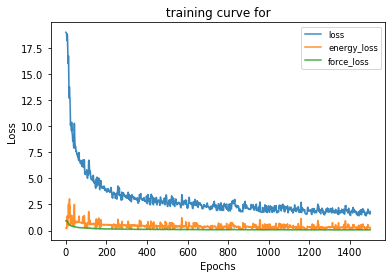

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.md.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates= "coords")],
    model_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="nuclear_charges", coordinates="coords")]
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17470.39086304]),
 'forces': array([[-2.7038932 ,  2.6439173 , -0.847476  ],
        [-0.84511614, -0.9075166 ,  1.9866856 ],
        [ 3.0425978 , -2.1348312 , -0.16465926],
        [-0.42968947,  1.6674011 , -0.11077674],
        [ 0.1685834 ,  1.7336547 ,  0.82665753],
        [-0.4765237 ,  0.2870181 , -0.13325322],
        [ 0.15645587,  0.7978637 , -2.1583302 ],
        [-0.33279866, -1.3463131 , -0.12431431],
        [ 0.5428426 ,  3.805442  ,  2.0322404 ],
        [-0.813529  ,  2.172956  ,  0.7618824 ],
        [ 1.2316663 , -1.2069573 ,  0.52432466],
        [ 0.44856313, -3.7534082 , -1.9189353 ],
        [ 1.8680558 , -0.96586424, -0.66541666],
        [-0.27304843, -0.6020769 ,  0.43181723],
        [ 1.1703918 , -1.8769183 ,  1.3733139 ],
        [ 0.07736456,  0.29660404, -0.82132065],
        [-1.1212312 ,  0.37746754, -0.1443955 ],
        [-0.44794455,  0.43599322, -0.20520338],
        [-0.2840122 , -1.0674332 , -0.6921195 ],
        [-0.46740854, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.md.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17470.3908625), 'forces': array([[-2.7038932 ,  2.6439176 , -0.8474757 ],
       [-0.8451168 , -0.90751565,  1.9866855 ],
       [ 3.0425968 , -2.134832  , -0.16465795],
       [-0.4296888 ,  1.6674011 , -0.11077818],
       [ 0.16858281,  1.7336549 ,  0.8266574 ],
       [-0.4765237 ,  0.28701848, -0.13325322],
       [ 0.15645656,  0.7978642 , -2.1583302 ],
       [-0.3327987 , -1.3463143 , -0.12431407],
       [ 0.5428424 ,  3.8054416 ,  2.03224   ],
       [-0.81352943,  2.172955  ,  0.7618829 ],
       [ 1.2316658 , -1.2069573 ,  0.5243244 ],
       [ 0.448564  , -3.753408  , -1.9189346 ],
       [ 1.8680558 , -0.96586406, -0.66541654],
       [-0.27304816, -0.6020769 ,  0.43181682],
       [ 1.1703917 , -1.8769178 ,  1.3733134 ],
       [ 0.07736444,  0.29660404, -0.8213204 ],
       [-1.1212306 ,  0.37746742, -0.14439557],
       [-0.44794416,  0.43599325, -0.2052033 ],
       [-0.28401226, -1.0674331 , -0.69211936],
       [-0.46740818,  0.3047396 , -0.5331961

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.923eV  Ekin = 0.049eV (T=377K)  Etot = -831.875eV


Energy per atom: Epot = -831.928eV  Ekin = 0.054eV (T=421K)  Etot = -831.873eV
Energy per atom: Epot = -831.927eV  Ekin = 0.055eV (T=427K)  Etot = -831.872eV
Energy per atom: Epot = -831.931eV  Ekin = 0.055eV (T=427K)  Etot = -831.875eV
Energy per atom: Epot = -831.932eV  Ekin = 0.065eV (T=501K)  Etot = -831.867eV
Energy per atom: Epot = -831.916eV  Ekin = 0.049eV (T=383K)  Etot = -831.866eV
Energy per atom: Epot = -831.924eV  Ekin = 0.057eV (T=442K)  Etot = -831.867eV
Energy per atom: Epot = -831.936eV  Ekin = 0.065eV (T=506K)  Etot = -831.870eV
Energy per atom: Epot = -831.930eV  Ekin = 0.058eV (T=446K)  Etot = -831.872eV
Energy per atom: Epot = -831.928eV  Ekin = 0.058eV (T=452K)  Etot = -831.870eV
Energy per atom: Epot = -831.932eV  Ekin = 0.065eV (T=504K)  Etot = -831.867eV
Energy per atom: Epot = -831.923eV  Ekin = 0.053eV (T=409K)  Etot = -831.870eV
Energy per atom: Epot = -831.925eV  Ekin = 0.055eV (T=426K)  Etot = -831.870eV
Energy per atom: Epot = -831.924eV  Ekin = 0.057eV (